In [ ]:
using LinearAlgebra
using Plots
using Printf

function rosenbrock(x::AbstractVector)
    n = length(x)
    sum(100.0 * (x[i+1] - x[i]^2)^2 + (1.0 - x[i])^2 for i in 1:n-1)
end

function rastrigin(x::AbstractVector)
    n = length(x)
    10n + sum(x[i]^2 - 10cos(2π * x[i]) for i in 1:n)
end

function schwefel(x::AbstractVector)
    n = length(x)
    418.9829 * n - sum(x[i] * sin(sqrt(abs(x[i]))) for i in 1:n)
end

function build_regular_simplex(x0::AbstractVector, ℓ::Real, n::Int)
    P = (1.0 / (n * sqrt(2))) * (sqrt(n + 1) + n - 1)
    Q = (1.0 / (n * sqrt(2))) * (sqrt(n + 1) - 1)
    vertices = Vector{Vector{Float64}}(undef, n + 1)
    vertices[1] = zeros(n)
    for i in 1:n
        v = fill(Q, n)
        v[i] = P
        vertices[i + 1] = v
    end
    for i in 1:n+1
        vertices[i] = x0 .+ ℓ .* vertices[i]
    end
    vertices
end

struct SimplexResult
    x_opt::Vector{Float64}
    f_opt::Float64
    iterations::Int
    simplex_history::Vector{Vector{Vector{Float64}}}
    sequence_points::Vector{Vector{Float64}}
    search_points_good::Vector{Vector{Float64}}
    search_points_bad::Vector{Vector{Float64}}
    f_history::Vector{Float64}
end

function simplex_method(f::Function, x0::AbstractVector, n::Int; ℓ::Real=1.0, ε::Real=1e-6, max_iter::Int=1000, L::Real=1.0, mode::Symbol=:single)
    vertices = build_regular_simplex(x0, ℓ, n)
    fvals = [f(v) for v in vertices]
    simplex_history = Vector{Vector{Vector{Float64}}}()
    sequence_points = Vector{Vector{Float64}}()
    search_points_good = Vector{Vector{Float64}}()
    search_points_bad = Vector{Vector{Float64}}()
    f_history = Float64[]
    push!(simplex_history, deepcopy(vertices))
    best_idx = argmin(fvals)
    push!(sequence_points, copy(vertices[best_idx]))
    push!(f_history, fvals[best_idx])
    current_ℓ = ℓ
    iter = 0
    while iter < max_iter
        iter += 1
        worst_idx = argmax(fvals)
        best_idx = argmin(fvals)
        max_edge = 0.0
        for i in 1:n+1, j in i+1:n+1
            max_edge = max(max_edge, norm(vertices[i] - vertices[j]))
        end
        max_edge < ε && break
        x_c = zeros(n)
        for i in 1:n+1
            i != worst_idx && (x_c .+= vertices[i])
        end
        x_c ./= n
        x_worst = vertices[worst_idx]
        direction = x_c .- x_worst
        replaced = false
        if mode == :single
            x_new = x_c .+ L .* direction
            f_new = f(x_new)
            push!(f_new < fvals[worst_idx] ? search_points_good : search_points_bad, copy(x_new))
            if f_new < fvals[worst_idx]
                vertices[worst_idx] = x_new
                fvals[worst_idx] = f_new
                replaced = true
            end
        elseif mode == :multi
            step_L = L
            best_x = copy(x_worst)
            best_f = fvals[worst_idx]
            for _ in 1:10
                x_cand = x_c .+ step_L .* direction
                f_cand = f(x_cand)
                if f_cand < best_f
                    push!(search_points_good, copy(x_cand))
                    best_x, best_f = copy(x_cand), f_cand
                    replaced = true
                    step_L *= 1.5
                else
                    push!(search_points_bad, copy(x_cand))
                    break
                end
            end
            if replaced
                vertices[worst_idx] = best_x
                fvals[worst_idx] = best_f
            end
        end

        if replaced
            push!(simplex_history, deepcopy(vertices))
            nb = argmin(fvals)
            push!(sequence_points, copy(vertices[nb]))
            push!(f_history, fvals[nb])
        else
            current_ℓ /= 2.0
            current_ℓ < ε && break
            vertices = build_regular_simplex(copy(vertices[best_idx]), current_ℓ, n)
            fvals = [f(v) for v in vertices]
            push!(simplex_history, deepcopy(vertices))
            nb = argmin(fvals)
            push!(sequence_points, copy(vertices[nb]))
            push!(f_history, fvals[nb])
        end
    end
    best_idx = argmin(fvals)
    SimplexResult(vertices[best_idx], fvals[best_idx], iter, simplex_history, sequence_points, search_points_good, search_points_bad, f_history)
end

get3d(v) = length(v) >= 3 ? (v[1],v[2],v[3]) : length(v) == 2 ? (v[1],v[2],0.0) : (v[1],0.0,0.0)

function plot_simplex_2d!(plt, verts; color=:black, alpha=0.3, lw=1)
    for i in 1:length(verts), j in i+1:length(verts)
        plot!(plt, [verts[i][1],verts[j][1]], [verts[i][2],verts[j][2]],
              color=color, alpha=alpha, lw=lw, label=false)
    end
end

function plot_simplex_3d!(plt, verts; color=:black, alpha=0.3, lw=1)
    for i in 1:length(verts), j in i+1:length(verts)
        a, b = get3d(verts[i]), get3d(verts[j])
        plot!(plt, [a[1],b[1]], [a[2],b[2]], [a[3],b[3]],
              color=color, alpha=alpha, lw=lw, label=false)
    end
end

extract_2d(pts) = isempty(pts) ? (Float64[],Float64[]) : ([p[1] for p in pts],[p[2] for p in pts])

function extract_3d(pts)
    isempty(pts) && return (Float64[],Float64[],Float64[])
    cs = [get3d(p) for p in pts]
    [c[1] for c in cs], [c[2] for c in cs], [c[3] for c in cs]
end

function visualize(result::SimplexResult, f::Function, name::String, n::Int; camera=(30,45), xlims_range=(-5.0,5.0), ylims_range=(-5.0,5.0), max_simplices::Int=50)
    ns = min(length(result.simplex_history), max_simplices)
    if n == 2
        xr = range(xlims_range[1], xlims_range[2], length=100)
        yr = range(ylims_range[1], ylims_range[2], length=100)
        Z = [f([x,y]) for y in yr, x in xr]
        p3 = surface(xr, yr, Z, alpha=0.4, color=:viridis, title="$name (3D)", xlabel="x₁", ylabel="x₂", zlabel="f(x)",
                     camera=camera, legend=false, colorbar=false, size=(700,550))
        for (k,s) in enumerate(result.simplex_history[1:ns])
            α = 0.2 + 0.5k/ns
            for i in 1:length(s), j in i+1:length(s)
                plot!(p3, [s[i][1],s[j][1]], [s[i][2],s[j][2]], [f(s[i]),f(s[j])], color=:black, alpha=α, lw=1, label=false)
            end
        end
        for sp in result.sequence_points
            scatter!(p3, [sp[1]], [sp[2]], [f(sp)], color=:green, ms=3, label=false, markerstrokewidth=0)
        end
        for sp in result.search_points_good
            scatter!(p3, [sp[1]], [sp[2]], [f(sp)], color=:blue, ms=2, label=false, markerstrokewidth=0)
        end
        for sp in result.search_points_bad
            scatter!(p3, [sp[1]], [sp[2]], [f(sp)], color=:red, ms=2, label=false, markerstrokewidth=0)
        end

        p2 = contour(xr, yr, Z, levels=30, fill=true, color=:viridis, alpha=0.5, title="$name (2D)", xlabel="x₁", ylabel="x₂",
                     legend=:outertopright, aspect_ratio=:equal, colorbar=false, size=(700,550))
        for (k,s) in enumerate(result.simplex_history[1:ns])
            α = 0.2 + 0.5k/ns
            col = k == 1 ? :white : (k == ns ? :yellow : :lightgray)
            plot_simplex_2d!(p2, s, color=col, alpha=α, lw=1.5)
        end
        xs,ys = extract_2d(result.sequence_points)
        !isempty(xs) && (scatter!(p2, xs, ys, color=:green, ms=5, label="Послед.", markerstrokewidth=0.5, markerstrokecolor=:black);
                         plot!(p2, xs, ys, color=:green, alpha=0.6, lw=1.5, label=false))
        xs,ys = extract_2d(result.search_points_good)
        !isempty(xs) && scatter!(p2, xs, ys, color=:blue, ms=3, label="Убыв.", markerstrokewidth=0)
        xs,ys = extract_2d(result.search_points_bad)
        !isempty(xs) && scatter!(p2, xs, ys, color=:red, ms=3, label="Возр.", markerstrokewidth=0)
        scatter!(p2, [result.x_opt[1]], [result.x_opt[2]], color=:gold, ms=10, markershape=:star5, label="Оптимум",
                 markerstrokewidth=1, markerstrokecolor=:black)
        return plot(p3, p2, layout=(1,2), size=(1500,650))
    else
        p3 = plot3d(title="$name (3D, n=$n)", xlabel="x₁", ylabel="x₂", zlabel="x₃", camera=camera, legend=:outertopright, size=(600,500))
        for (k,s) in enumerate(result.simplex_history[1:ns])
            α = 0.1 + 0.6k/ns
            col = k == 1 ? :gray : (k == ns ? :black : :lightgray)
            plot_simplex_3d!(p3, s, color=col, alpha=α, lw=1)
        end
        xs,ys,zs = extract_3d(result.sequence_points)
        !isempty(xs) && (scatter!(p3, xs, ys, zs, color=:green, ms=4, label="Послед.", markerstrokewidth=0);
                         plot!(p3, xs, ys, zs, color=:green, alpha=0.4, lw=1, label=false))
        xs,ys,zs = extract_3d(result.search_points_good)
        !isempty(xs) && scatter!(p3, xs, ys, zs, color=:blue, ms=3, label="Убыв.", markerstrokewidth=0)
        xs,ys,zs = extract_3d(result.search_points_bad)
        !isempty(xs) && scatter!(p3, xs, ys, zs, color=:red, ms=3, label="Возр.", markerstrokewidth=0)
        xo = length(result.x_opt) >= 3 ? result.x_opt[1:3] : [result.x_opt; zeros(3-length(result.x_opt))]
        scatter!(p3, [xo[1]], [xo[2]], [xo[3]], color=:gold, ms=8, markershape=:star5, label="Оптимум", markerstrokewidth=1)

        p2 = plot(title="$name (2D x₁-x₂)", xlabel="x₁", ylabel="x₂",
                  legend=:outertopright, aspect_ratio=:equal, size=(600,500))
        for (k,s) in enumerate(result.simplex_history[1:ns])
            α = 0.1 + 0.6k/ns
            col = k == 1 ? :gray : (k == ns ? :black : :lightgray)
            plot_simplex_2d!(p2, s, color=col, alpha=α, lw=1)
        end
        xs,ys = extract_2d(result.sequence_points)
        !isempty(xs) && (scatter!(p2, xs, ys, color=:green, ms=4, label="Послед.", markerstrokewidth=0);
                         plot!(p2, xs, ys, color=:green, alpha=0.4, lw=1, label=false))
        xs,ys = extract_2d(result.search_points_good)
        !isempty(xs) && scatter!(p2, xs, ys, color=:blue, ms=3, label="Убыв.", markerstrokewidth=0)
        xs,ys = extract_2d(result.search_points_bad)
        !isempty(xs) && scatter!(p2, xs, ys, color=:red, ms=3, label="Возр.", markerstrokewidth=0)
        scatter!(p2, [result.x_opt[1]], [result.x_opt[2]],
                 color=:gold, ms=8, markershape=:star5, label="Оптимум", markerstrokewidth=1)
        return plot(p3, p2, layout=(1,2), size=(1400,600))
    end
end

function create_rotation_gif(result::SimplexResult, f::Function, name::String, n::Int;
                              filename::String="rotation.gif", n_frames::Int=36, max_simplices::Int=50)
    ns = min(length(result.simplex_history), max_simplices)
    anim = @animate for angle in range(0, 360, length=n_frames)
        if n == 2
            xr = range(-5, 5, length=80)
            yr = range(-5, 5, length=80)
            Z = [f([x,y]) for y in yr, x in xr]
            plt = surface(xr, yr, Z, alpha=0.3, color=:viridis, title="$name",
                          xlabel="x₁", ylabel="x₂", zlabel="f(x)",
                          camera=(angle,30), colorbar=false, legend=false, size=(800,600))
            for (k,s) in enumerate(result.simplex_history[1:ns])
                α = 0.3 + 0.5k/ns
                for i in 1:length(s), j in i+1:length(s)
                    plot!(plt, [s[i][1],s[j][1]], [s[i][2],s[j][2]], [f(s[i]),f(s[j])],
                          color=:black, alpha=α, lw=1, label=false)
                end
            end
            for sp in result.sequence_points
                scatter!(plt, [sp[1]], [sp[2]], [f(sp)], color=:green, ms=3, label=false, markerstrokewidth=0)
            end
        else
            plt = plot3d(title="$name (n=$n)", xlabel="x₁", ylabel="x₂", zlabel="x₃",
                         camera=(angle,30), legend=false, size=(800,600))
            for (k,s) in enumerate(result.simplex_history[1:ns])
                α = 0.15 + 0.6k/ns
                plot_simplex_3d!(plt, s, color=:black, alpha=α, lw=1)
            end
            xs,ys,zs = extract_3d(result.sequence_points)
            !isempty(xs) && (scatter!(plt, xs, ys, zs, color=:green, ms=4, label=false, markerstrokewidth=0);
                             plot!(plt, xs, ys, zs, color=:green, alpha=0.4, lw=1, label=false))
            xs,ys,zs = extract_3d(result.search_points_good)
            !isempty(xs) && scatter!(plt, xs, ys, zs, color=:blue, ms=3, label=false, markerstrokewidth=0)
            xs,ys,zs = extract_3d(result.search_points_bad)
            !isempty(xs) && scatter!(plt, xs, ys, zs, color=:red, ms=3, label=false, markerstrokewidth=0)
        end
    end
    gif(anim, filename, fps=8)
    filename
end

function run_all_tests()
    funcs = [(rosenbrock,"Розенброк",(-3.0,3.0)),
             (rastrigin,"Растригин",(-5.12,5.12)),
             (schwefel,"Швефель",(-500.0,500.0))]
    println("=" ^ 80)
    println("МЕТОД ПРОСТЫХ СИМПЛЕКСОВ — ТЕСТИРОВАНИЕ")
    println("=" ^ 80)
    for (func,name,_) in funcs, n in [2,3,4]
        println("\n--- $name, n=$n ---")
        ℓ = n == 2 ? 1.0 : 2.0
        rs = simplex_method(func, zeros(n), n; ℓ=ℓ, ε=1e-8, max_iter=2000, mode=:single) #fill(x, n)
        rm = simplex_method(func, zeros(n), n; ℓ=ℓ, ε=1e-8, max_iter=2000, mode=:multi)
        @printf("  Single: f*=%.6e, шагов=%d, точек=%d\n", rs.f_opt, rs.iterations, length(rs.sequence_points))
        @printf("  Multi:  f*=%.6e, шагов=%d, точек=%d\n", rm.f_opt, rm.iterations, length(rm.sequence_points))
        @printf("  x*(single)=%s\n", string(round.(rs.x_opt, digits=6)))
        @printf("  x*(multi) =%s\n", string(round.(rm.x_opt, digits=6)))
    end
end

function generate_visualizations(outdir::String="let1")
    mkpath(outdir)
    funcs = [(rosenbrock,"Розенброк",(-3.0,3.0)),
             (rastrigin,"Растригин",(-5.12,5.12)),
             (schwefel,"Швефель",(-500.0,500.0))]
    for (func,name,(lo,hi)) in funcs
        tag = lowercase(replace(name, ' '=>'_'))
        for n in [2,3,4]
            ℓ = n == 2 ? 1.0 : 2.0
            r = simplex_method(func, zeros(n), n; ℓ=ℓ, ε=1e-8, max_iter=2000, mode=:single)
            plt = visualize(r, func, name, n; xlims_range=(lo,hi), ylims_range=(lo,hi))
            savefig(plt, joinpath(outdir, "$(tag)_n$(n).png"))
            println("Сохранено: $(outdir)/$(tag)_n$(n).png")
            n <= 3 && (create_rotation_gif(r, func, name, n; filename=joinpath(outdir, "$(tag)_n$(n)_rot.gif"));
                       println("Сохранено: $(outdir)/$(tag)_n$(n)_rot.gif"))
        end
    end
    table_path = joinpath(outdir, "comparison.txt")
    open(table_path, "w") do io
        println(io, "=" ^ 60)
        println(io, "СРАВНЕНИЕ РЕЖИМОВ")
        println(io, "=" ^ 60)
        @printf(io, "%-12s %-3s %-9s %-9s %-9s %-9s\n", "Функция","n","Sin:шаг","Sin:точ","Mul:шаг","Mul:точ")
        println(io, "-" ^ 60)
        for (func,name,_) in funcs, n in [2,3,4]
            ℓ = n == 2 ? 1.0 : 2.0
            rs = simplex_method(func, zeros(n), n; ℓ=ℓ, ε=1e-8, max_iter=2000, mode=:single)
            rm = simplex_method(func, zeros(n), n; ℓ=ℓ, ε=1e-8, max_iter=2000, mode=:multi)
            @printf(io, "%-12s %-3d %-9d %-9d %-9d %-9d\n", name, n, rs.iterations, length(rs.sequence_points), rm.iterations, length(rm.sequence_points))
        end
    end
    println("Сохранено: $(table_path)")
end

generate_visualizations (generic function with 2 methods)

In [4]:
run_all_tests()
generate_visualizations("let1")
println("\nГотово! Все файлы в директории let1/")

МЕТОД ПРОСТЫХ СИМПЛЕКСОВ — ТЕСТИРОВАНИЕ

--- Розенброк, n=2 ---
  Single: f*=2.632204e-02, шагов=2000, точек=2001
  Multi:  f*=5.470777e-02, шагов=100, точек=100
  x*(single)=[0.837842, 0.701461]
  x*(multi) =[0.772494, 0.591316]

--- Розенброк, n=3 ---
  Single: f*=1.142595e-01, шагов=2000, точек=2001
  Multi:  f*=2.141400e-01, шагов=141, точек=141
  x*(single)=[0.839067, 0.703497, 0.492865]
  x*(multi) =[0.774292, 0.598804, 0.353892]

--- Розенброк, n=4 ---
  Single: f*=2.683744e-01, шагов=2000, точек=2001
  Multi:  f*=5.138684e-01, шагов=177, точек=177
  x*(single)=[0.868305, 0.75259, 0.565516, 0.317015]
  x*(multi) =[0.819127, 0.656776, 0.422, 0.180011]

--- Растригин, n=2 ---
  Single: f*=0.000000e+00, шагов=31, точек=31
  Multi:  f*=0.000000e+00, шагов=31, точек=31
  x*(single)=[0.0, 0.0]
  x*(multi) =[0.0, 0.0]

--- Растригин, n=3 ---
  Single: f*=0.000000e+00, шагов=39, точек=39
  Multi:  f*=0.000000e+00, шагов=39, точек=39
  x*(single)=[0.0, 0.0, 0.0]
  x*(multi) =[0.0, 0.0, 0

┌ Info: Saved animation to c:\programming\optimization-methods\let1\розенброк_n2_rot.gif
└ @ Plots C:\Users\Admin\.julia\packages\Plots\xKhUG\src\animation.jl:156


Сохранено: let1/розенброк_n3.png
Сохранено: let1/розенброк_n3_rot.gif
Сохранено: let1/розенброк_n4.png

┌ Info: Saved animation to c:\programming\optimization-methods\let1\розенброк_n3_rot.gif
└ @ Plots C:\Users\Admin\.julia\packages\Plots\xKhUG\src\animation.jl:156



Сохранено: let1/растригин_n2.png
Сохранено: let1/растригин_n2_rot.gif


┌ Info: Saved animation to c:\programming\optimization-methods\let1\растригин_n2_rot.gif
└ @ Plots C:\Users\Admin\.julia\packages\Plots\xKhUG\src\animation.jl:156


Сохранено: let1/растригин_n3.png
Сохранено: let1/растригин_n3_rot.gif


┌ Info: Saved animation to c:\programming\optimization-methods\let1\растригин_n3_rot.gif
└ @ Plots C:\Users\Admin\.julia\packages\Plots\xKhUG\src\animation.jl:156


Сохранено: let1/растригин_n4.png
Сохранено: let1/швефель_n2.png
Сохранено: let1/швефель_n2_rot.gif
Сохранено: let1/швефель_n3.png

┌ Info: Saved animation to c:\programming\optimization-methods\let1\швефель_n2_rot.gif
└ @ Plots C:\Users\Admin\.julia\packages\Plots\xKhUG\src\animation.jl:156



Сохранено: let1/швефель_n3_rot.gif


┌ Info: Saved animation to c:\programming\optimization-methods\let1\швефель_n3_rot.gif
└ @ Plots C:\Users\Admin\.julia\packages\Plots\xKhUG\src\animation.jl:156


Сохранено: let1/швефель_n4.png
Сохранено: let1\comparison.txt

Готово! Все файлы в директории let1/


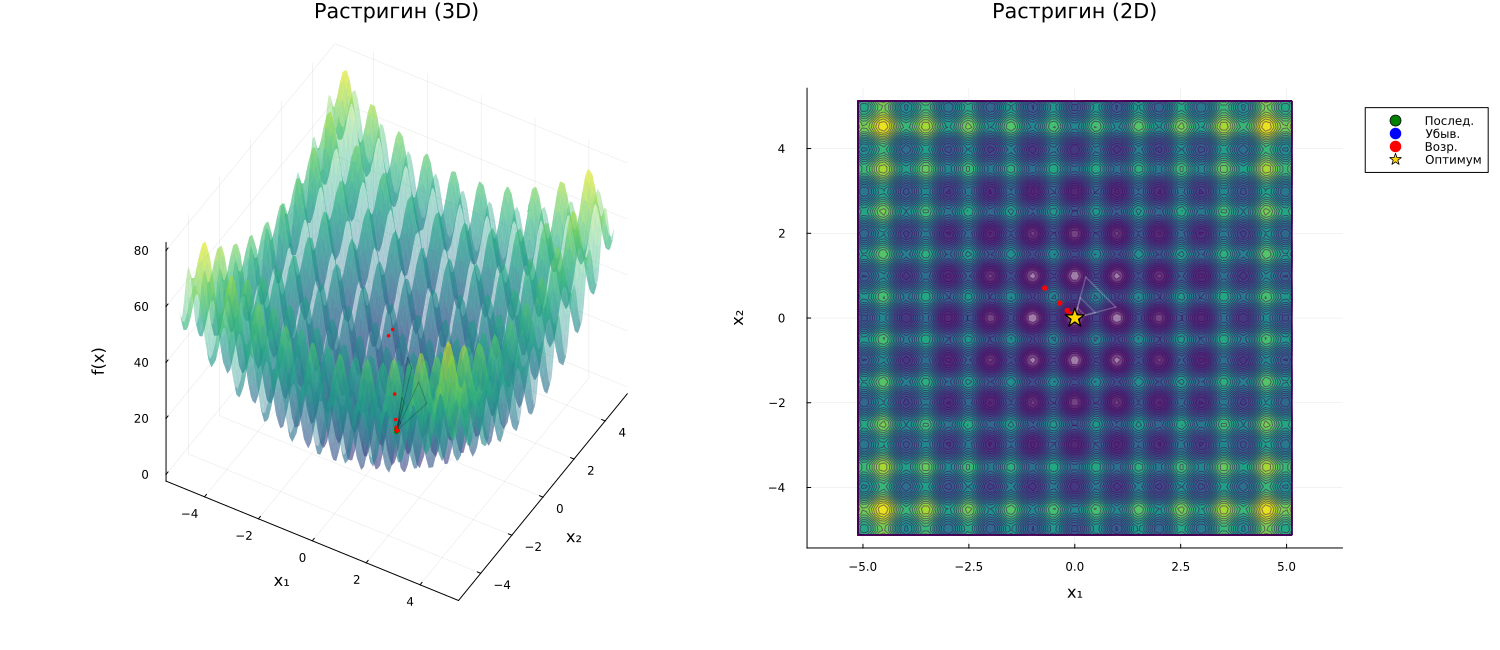
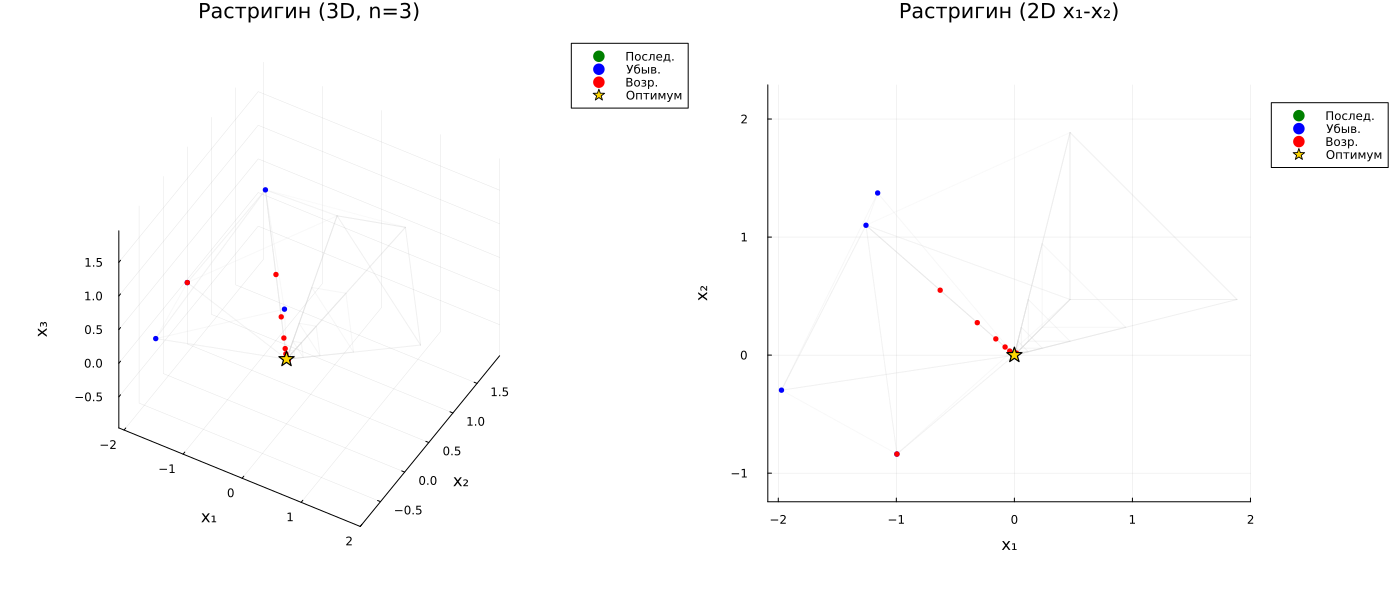
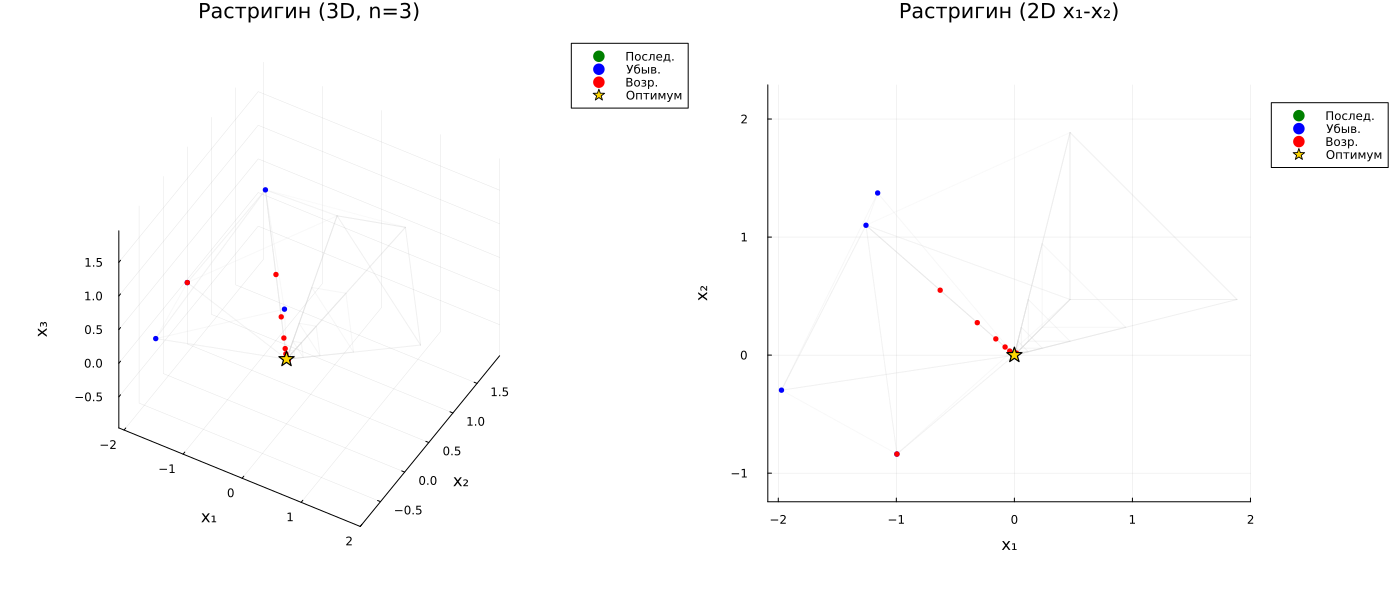
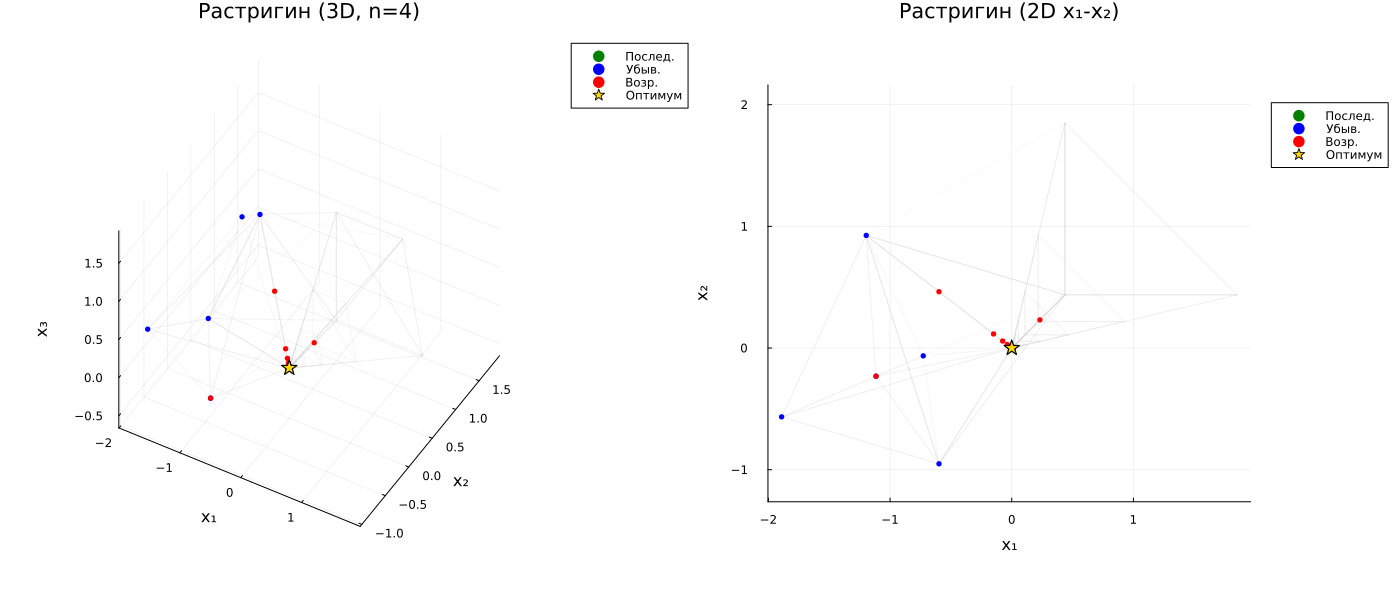
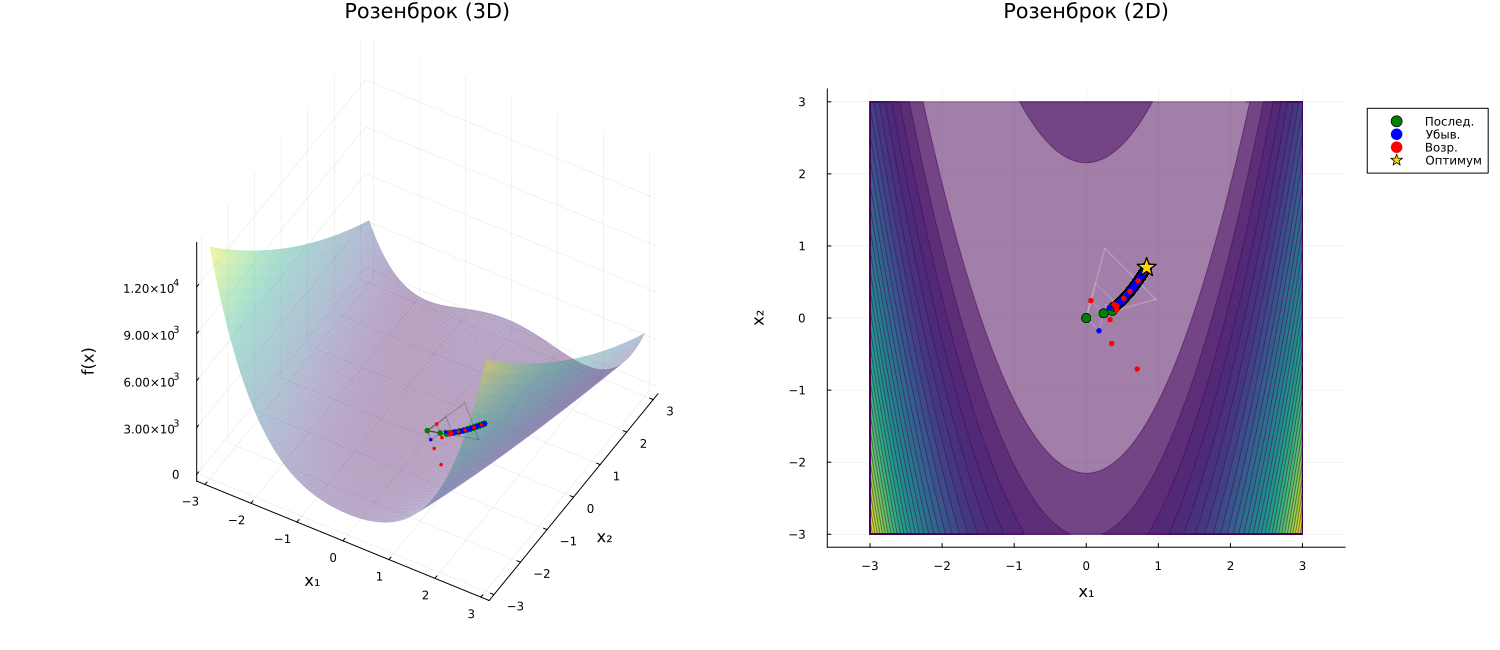
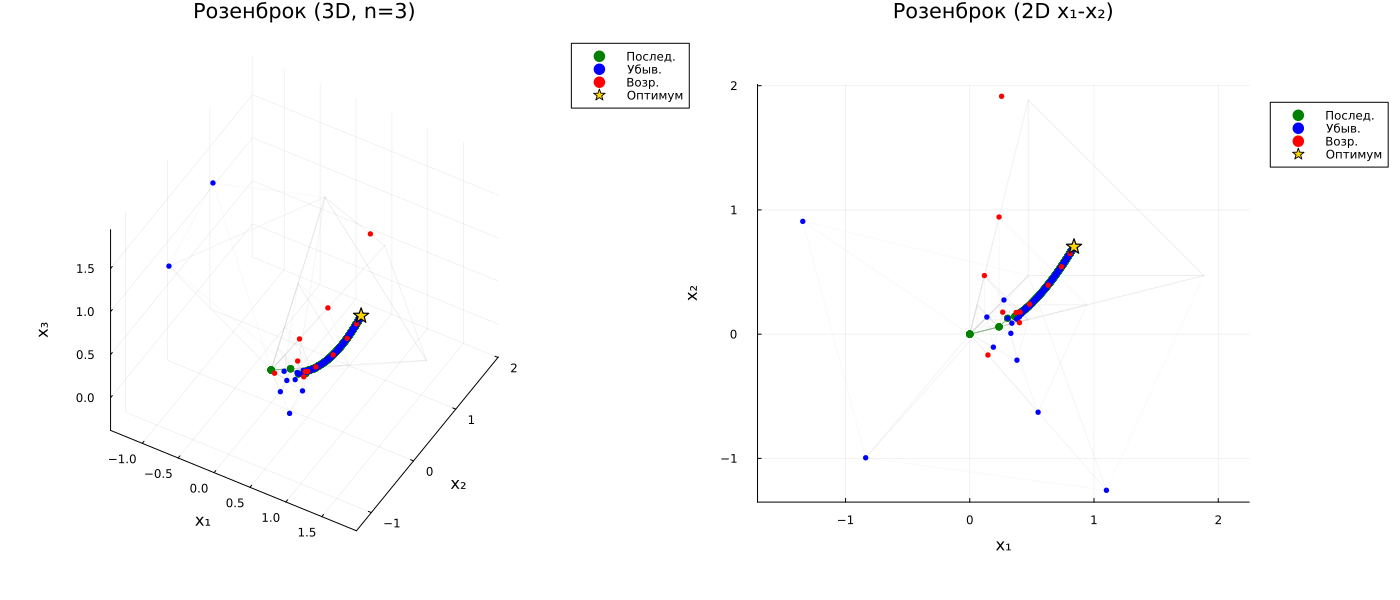
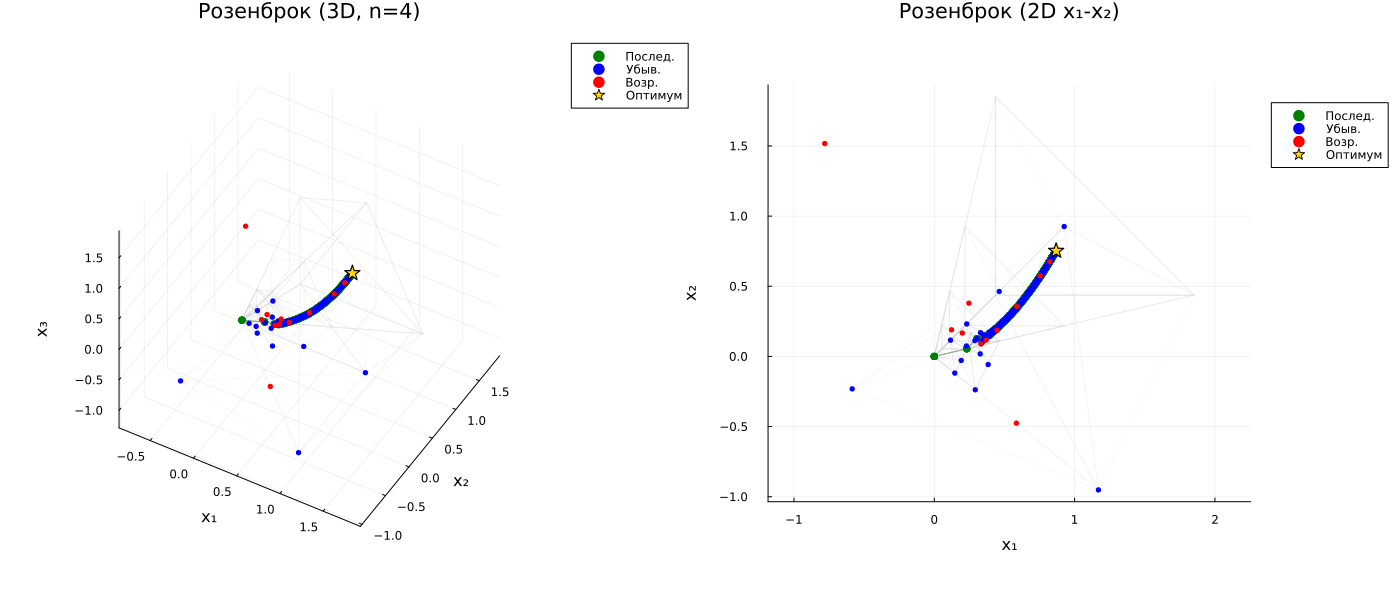
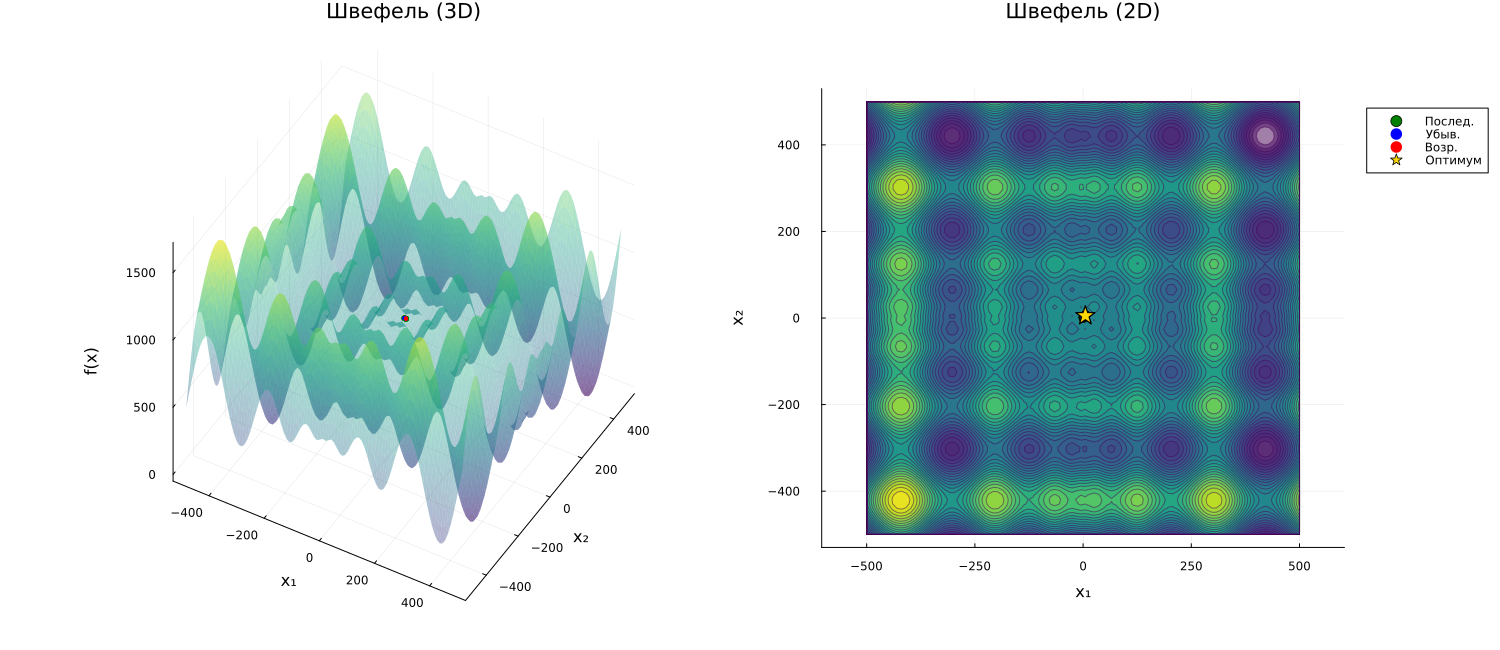
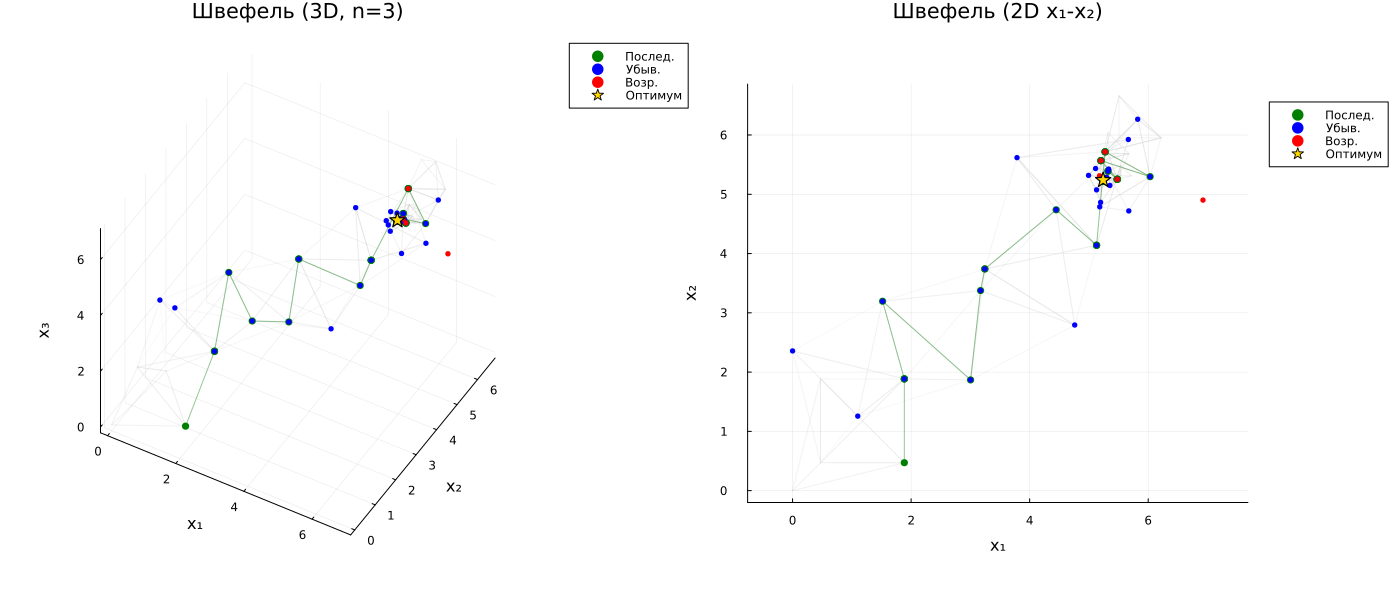
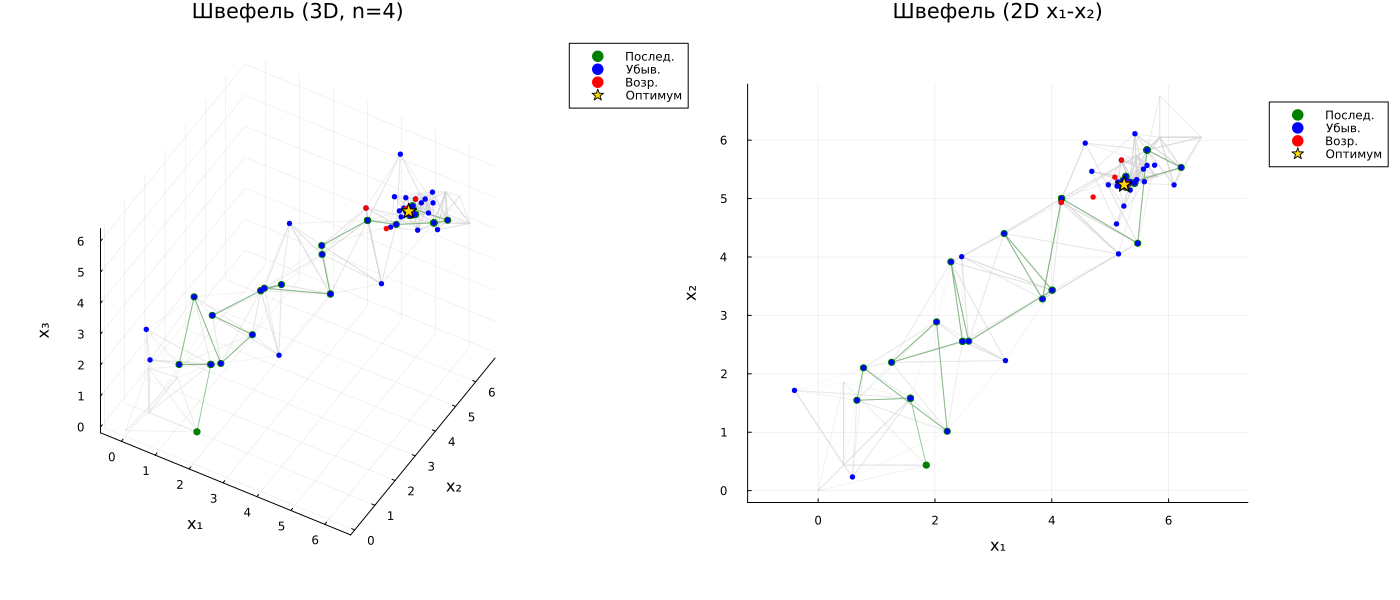